In [1]:
import numpy as n
import aipy as a
import pylab as pl
import xrfi
import torch
import torch.nn as nn
from torch.autograd import Variable
from glob import glob
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [129]:
def loadFullDay():
    HERAlist = glob('/Users/josh/Desktop/HERA/data/zen.2457458.*.xx.HH.uvcUA')
    HERAdata = []
    times = []
    for k in HERAlist:
        uvHERA = a.miriad.UV(k)
        a.scripting.uv_selector(uvHERA, '9_10', 'xx')
        #temp = []
        for p,d,f in uvHERA.all(raw=True):
            #temp.append(d)
            HERAdata.append(d)
            times.append(uvHERA['lst'])
            #HERAdata.append(temp)
    HERAdata = n.array(HERAdata)
    times = n.array(times)
    return HERAdata,times

def loadSingleDay():
    HERAlist = glob('/Users/josh/Desktop/HERA/data/zen.2457458.*.xx.HH.uvcU')
    HERAdata = []
    times = []
    for k in HERAlist:
        uvHERA = a.miriad.UV(k)
        a.scripting.uv_selector(uvHERA, '31_105', 'xx')
        for p,d,f in uvHERA.all(raw=True):
            HERAdata.append(d)
            times.append(uvHERA['lst'])
    HERAdata = n.array(HERAdata)
    times = n.array(times)
    return HERAdata,times

def expandMask(data,mask,batch):
    sh = n.shape(mask)
    expData = data
    expMask = mask
    for i in range(batch):
        expData = n.vstack((expData,data+0.01*n.random.randn()*(n.random.randn(sh[0],sh[1])+ 1j*n.random.randint(-1,2)*n.random.randn(sh[0],sh[1]))))
        expMask = n.vstack((expMask,mask))
    return expData,expMask

def injectRandomRFI(data,mask,injections):
    sh = n.shape(data)
    print sh
    outD = n.copy(data)
    outM = n.copy(mask)
    for i in range(injections):
        if n.abs(n.random.rand())>0.5:
            ## RFI across time                                                                                                                                             
            fw = n.random.randint(1,3)+1
            th = n.random.randint(1,900)+1
            fs = n.random.randint(1,sh[1]-fw)
            ts = n.random.randint(1,sh[0]-th)
            outD[ts:ts+th,fs:fs+fw] = outD[ts:ts+th,fs:fs+fw]+0.01*n.random.randn()*(n.random.randn(th,fw)+ 1j*n.random.randint(-1,2)*n.random.randn(th,fw))
            outM[ts:ts+th,fs:fs+fw] = 0.
        else:
            ## RFI across freq                                                                                                                                             
            fw = n.random.randint(1,100)+1
            th = n.random.randint(1,3)+1
            fs = n.random.randint(1,sh[1]-fw)
            ts = n.random.randint(1,sh[0]-th)
            outD[ts:ts+th,fs:fs+fw] = outD[ts:ts+th,fs:fs+fw]+0.01*n.random.randn()*(n.random.randn(th,fw)+ 1j*n.random.randint(-1,2)*n.random.randn(th,fw))
            outM[ts:ts+th,fs:fs+fw] = 0.
        del(fw)
        del(th)
    return outD,outM

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 2, kernel_size=1, padding=0),
            nn.BatchNorm2d(2),
            nn.Dropout(p=0.2),
            nn.Tanh())

        self.layer2 = nn.Sequential(
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.Tanh())

        self.layer3 = nn.Sequential(
            nn.Conv2d(2, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.Dropout(p=0.2),
            nn.Tanh())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh())

        self.layer5 = nn.Sequential(
            #nn.Conv2d(4, 1, kernel_size=1, padding=0),
            #nn.BatchNorm2d(1),
            nn.Linear(1024,1024),
            nn.Tanh())
        self.fc = nn.Linear(1024, 2*1024)

    def forward(self, x):
        out = self.layer1(x).view(1,2,-1,1024)
        out = self.layer2(out).view(1,2,-1,1024)
        out = self.layer3(out).view(1,2,-1,1024)
        #print out.size()
        out = self.layer4(out).view(-1,1024)
        out = out.float()
        out = self.layer5(out).view(1,1,-1,1024)
        #print out.size()
        out = out.view(-1, 1024).float()
        out = self.fc(out)
        return out
    
def FFT(data):
    DATA = n.fft.fft(data,axis=1)
    DATA_ = n.fft.fftshift(DATA,axes=1)
    return DATA_

(312, 50, 1024, 1)


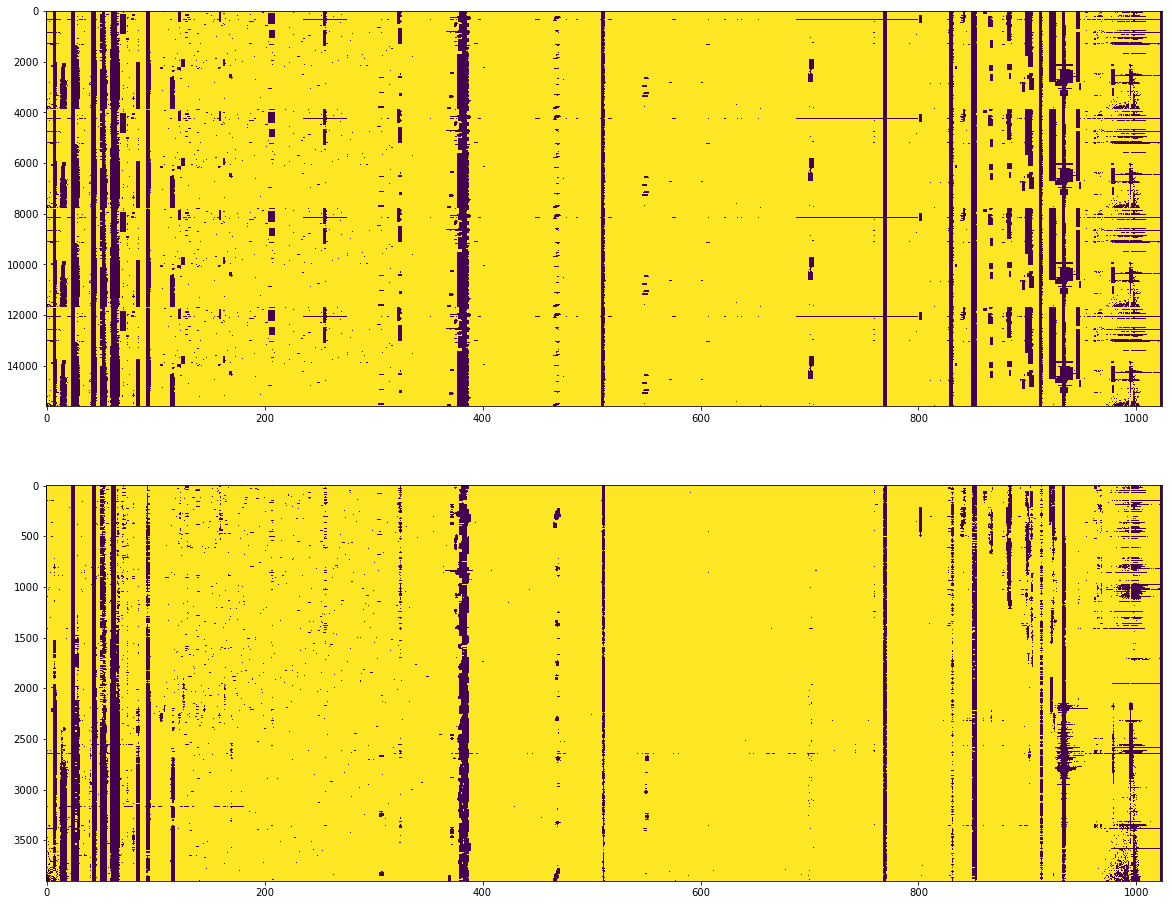

(15600, 1024)


In [130]:
#### Import a day of data ####
DATA,times = loadFullDay()
DATA = DATA[0:3900,:]
XRFImask = xrfi.xrfi_simple(DATA)
mask = n.loadtxt('trainMask_HQ.txt')[0:3900,:]*n.logical_not(XRFImask[0:3900,:]).astype(int) 
DATA,mask = expandMask(DATA,mask,3)

batch_size = 5
#DATA1 = n.array([n.real(DATA),n.imag(DATA)])

print DATA1.shape
### Old approach of moving average and preset variance threshold


pl.subplot(211)
pl.imshow(mask,aspect='auto',interpolation='none')
pl.subplot(212)
pl.imshow(n.logical_not(XRFImask),aspect='auto',interpolation='none')
pl.show()

DATA1,MASK1 = injectRandomRFI(DATA,mask,400)
MASK1 = n.array(mask).reshape(4*78,-1,1024,1)
DATA1 = DATA
#MASK1 = n.array([mask,mask]).reshape(1,-1,1024,2)
#data1,mask1 = expandMask(DATA,mask,3)

DATA1 = n.abs(DATA)
DATA1 = DATA1/n.max(DATA1)
DATA1 = DATA1.reshape(4*78,-1,1024,1)
data1 = torch.from_numpy(DATA1)
mask1 = torch.from_numpy(MASK1)
train_dataset = TensorDataset(data1,mask1)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

0.697023928165
0.620732307434
0.463898867369
0.298060953617
0.162044942379
0.153152689338
0.133647829294
0.0952055603266
0.147597387433
0.109127759933
0.136770814657
0.19231069088
0.133718699217
0.173918262124
0.152471482754
0.140086293221
0.14408954978
0.111396327615
0.117246501148
0.110476821661
0.232010632753
0.129201814532
0.101859919727
0.224330917001
0.155829846859
0.0981261208653
0.121905267239
0.0994971171021
0.134226202965
0.148503780365
0.128585934639
0.161701232195
0.111074969172
0.100929409266
0.114680178463
0.106720432639
0.142166987062
0.116618834436
0.105107754469
0.0973571613431
0.0888895615935
0.076955601573
0.105084754527
0.0845756754279
0.135155186057
0.0892358422279
0.0944814607501
0.120102360845
0.141400203109
0.282043784857
0.196328416467
0.192223027349
0.144736111164
0.0919973403215
0.0977472141385
0.0994714125991
0.13403891027
0.0895982161164
0.143285363913
0.0742509290576
0.12540563941
0.145186439157
0.0668278709054
0.103930473328
0.0792195871472
0.102993793786

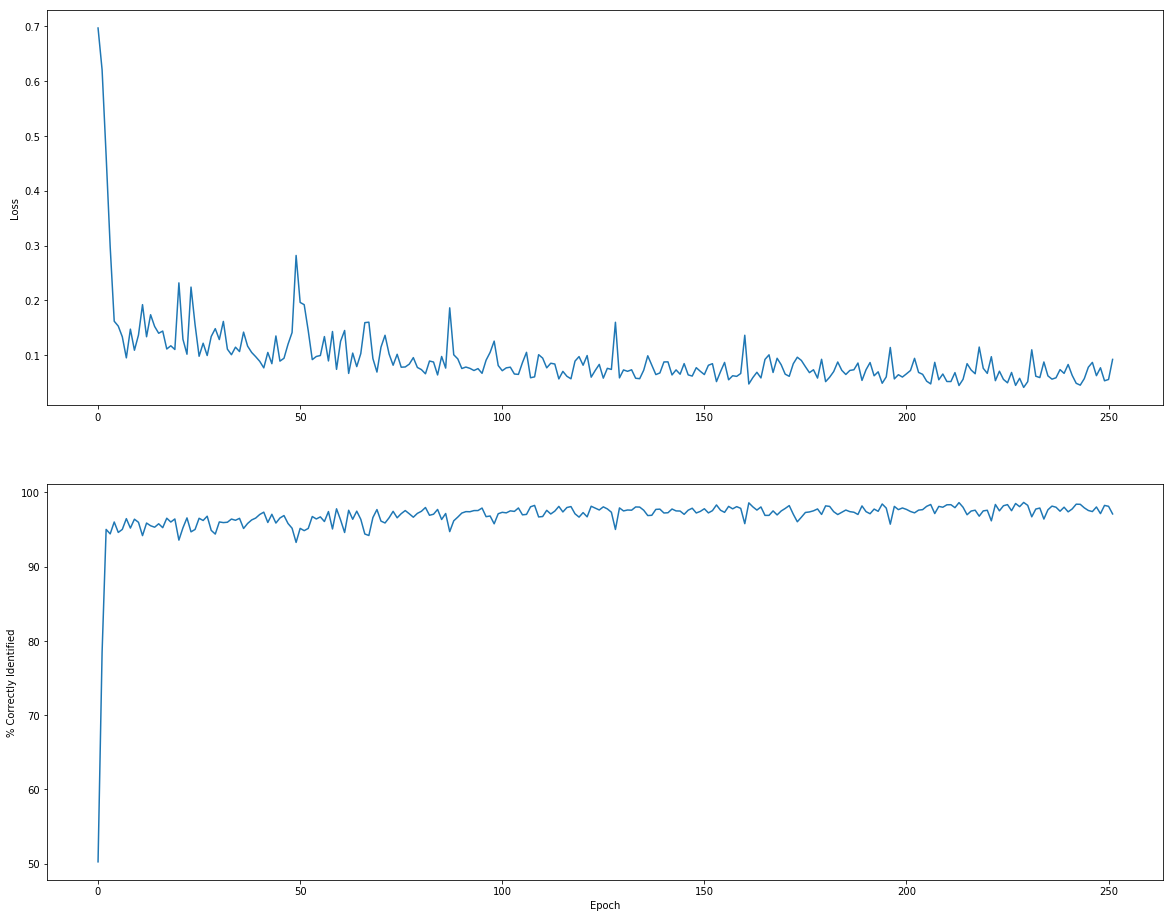

In [131]:
# Hyper Parameters                                                                                                                                                         
num_epochs = 4
batch_size = 78
learning_rate = 0.001
cnn = CNN()
# Loss and Optimizer                                                                                                                                                       
criterion = nn.CrossEntropyLoss()                                                                                                                                                 
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_array = []
correct = []
# Train the Model 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).float()
        #print labels[0,:,:,0].size()
        labels = Variable(labels[:,:,:,0]).long().view(-1)
        # Forward + Backward + Optimize                                                                                                                                    
        optimizer.zero_grad()
        images = images.view(1,1,-1,1024)
        outputs = cnn(images)                                                                                                                                       
        outputs = outputs.view(-1,2)
        loss = criterion(outputs.float(), labels.long())
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct.append(1.0*(predicted.int()==labels.data.int()).sum()/labels.size()[0])
        loss_array.append(loss.data[0])
        print loss.data[0]
        #if (i+1) % 100 == 0:                                                                                                                                              
        #print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
#torch.save(cnn, 'DEEPcnn.txt')
print loss_array[-1]
pl.subplot(211)
pl.plot(loss_array)
pl.ylabel('Loss')
pl.xlabel('')
pl.subplot(212)
pl.plot(n.array(correct)*100.)
pl.ylabel('% Correctly Identified')
pl.xlabel('Epoch')
pl.show()

In [124]:
print correct[-1]

0.988232421875


In [125]:
#cnn = torch.load('/Users/josh/Desktop/HERA/RFINeural/DEEPcnn.txt')
DATA = DATA.reshape(-1,1024)
bh = a.dsp.gen_window(1024,window='blackman-harris')
#dataNN = n.array([n.abs(DATA),n.angle(DATA)]).reshape(1,-1,1024,2)
dataNN = n.abs(DATA).reshape(1,1,-1,1024)
dataNN = dataNN/n.max(dataNN)
data1 = torch.Tensor(dataNN)
data1V = Variable(data1)
data1V = data1V.view(1,1,-1,1024)
sh = n.shape(DATA)                                                                                                                                      
maskV = cnn(data1V)
maskV = maskV.view(-1,2)
_, predicted = torch.max(maskV.data, 1)
maskPred = n.round(predicted.numpy())
maskPred = maskPred.reshape(-1,1024)
maskPred = n.abs(maskPred).astype(bool)
dataXRFI = n.abs(FFT(bh*DATA[0:3900,:]*n.logical_not(XRFImask)))
dataCNN = n.abs(FFT(bh*DATA*n.abs(maskPred)))

/Users/josh/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


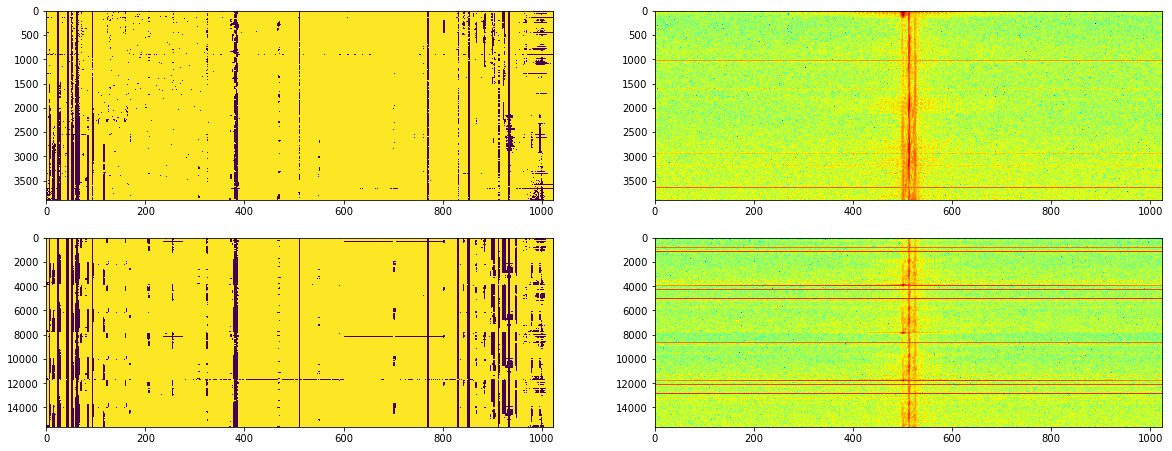

In [126]:
pl.rcParams['figure.figsize'] = (20, 16)
pl.subplot(421)
pl.imshow(n.logical_not(XRFImask),aspect='auto',interpolation='none')
pl.subplot(423)
pl.imshow(maskPred,aspect='auto',interpolation='none')
pl.subplot(422)
pl.imshow(n.log10(dataXRFI),aspect='auto',interpolation='none',cmap='jet')
pl.subplot(424)
pl.imshow(n.log10(dataCNN),aspect='auto',interpolation='none',cmap='jet')
pl.show()

In [119]:
pl.imshow(n.logical_not(XRFImask) - maskPred,aspect='auto',interpolation='none')
pl.show()

/Users/josh/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


ValueError: operands could not be broadcast together with shapes (3900,1024) (15600,1024) 

In [127]:
#### Now load a single obs with a different baseline
cnn.eval()
singObs,singTimes = loadSingleDay()
XRFImsin = n.logical_not(xrfi.xrfi_simple(singObs)).astype(int)
sobsNN = n.abs(singObs)
sobsNN = sobsNN/n.max(sobsNN)
sobs1 = torch.Tensor(sobsNN)
sobs1V = Variable(sobs1)
sobs1V = sobs1V.view(1,1,-1,1024)
sh = n.shape(sobsNN)                                                                                                                                         
msinV = cnn(sobs1V)
msinV = msinV.view(-1,2)
_, singPred = torch.max(msinV.data, 1)
msinPred = n.round(singPred.numpy())
msinPred = msinPred.reshape(sh[0],sh[1])
msinPred = n.abs(msinPred).astype(bool)
sinXRFI = n.abs(FFT(bh*singObs*XRFImsin))
sinCNN = n.abs(FFT(bh*singObs*msinPred))

/Users/josh/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


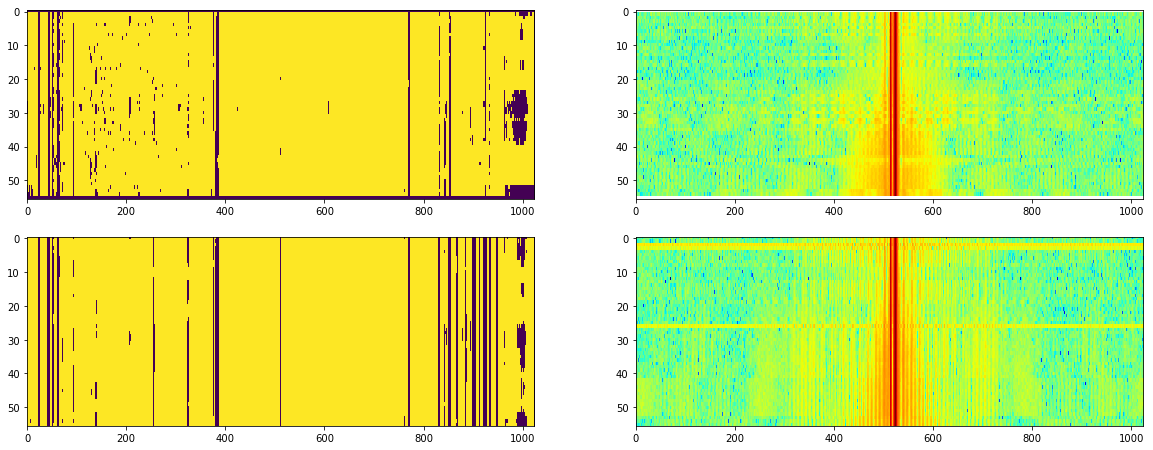

In [128]:
pl.rcParams['figure.figsize'] = (20, 16)
pl.subplot(421)
pl.imshow(XRFImsin,aspect='auto',interpolation='none')
pl.subplot(423)
pl.imshow(msinPred,aspect='auto',interpolation='none')
pl.subplot(422)
pl.imshow(n.log10(sinXRFI),aspect='auto',interpolation='none',cmap='jet')
pl.subplot(424)
pl.imshow(n.log10(sinCNN),aspect='auto',interpolation='none',cmap='jet')
pl.show()

/Users/josh/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


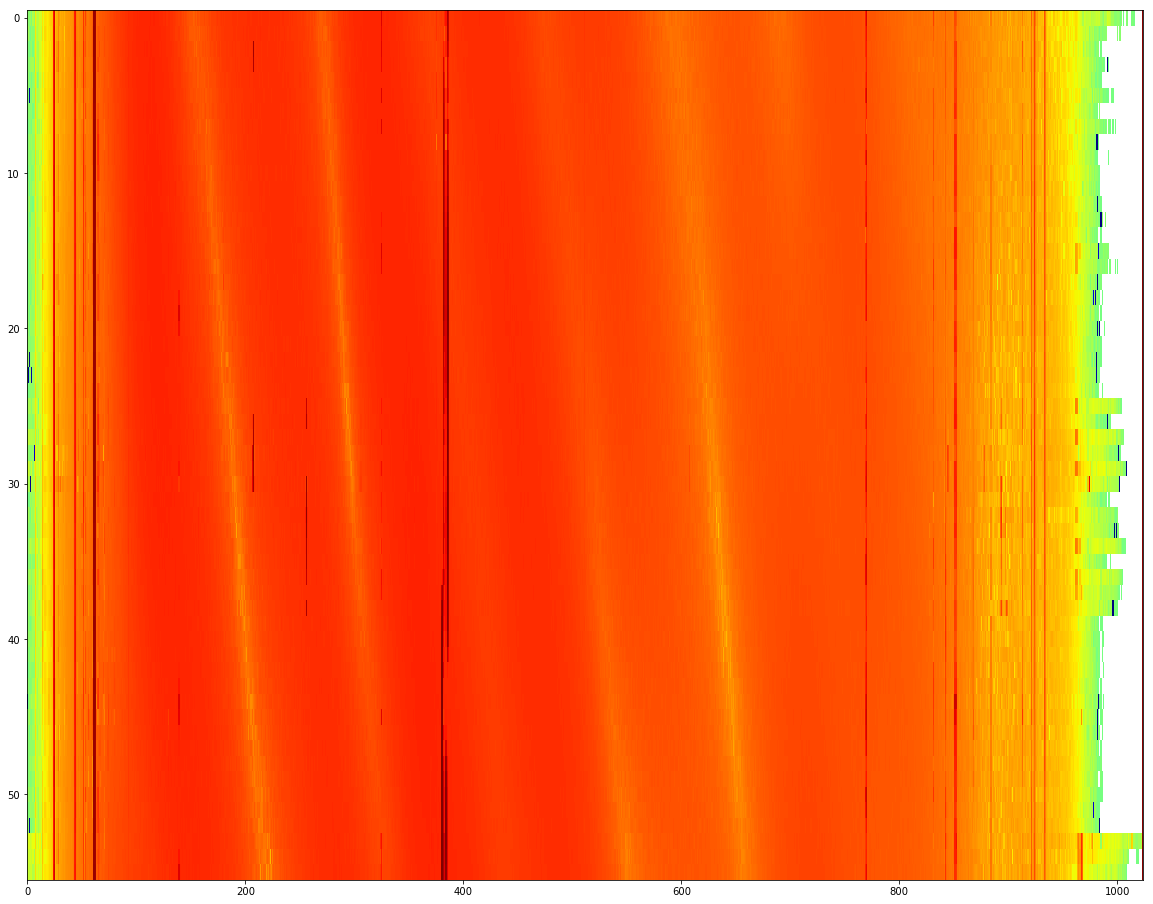

In [528]:
pl.imshow(n.log10(n.abs(singObs)),aspect='auto',interpolation='none',cmap='jet')
pl.show()